<a href="https://colab.research.google.com/github/hayden-huynh/Facial-Expression-Image-Classifier/blob/master/Facial_Expression_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note about References
- The reference(s) are placed in comment(s) at top of the code block
- The lines of codes that are copied from a reference are wrapped around by that reference number

# Download dataset from Kaggle

In [ ]:
# Download the facial expression dataset from Kaggle
# Reference 1: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

# Ref 1 starts =====
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download samaneheslamifar/facial-emotion-expressions
! unzip facial-emotion-expressions.zip
# ===== Ref 1 ends

# Label the dataset

In [2]:
# Label the dataset images into csv files

import os
import csv

label_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

train_csv = open("train_labels.csv", "w")
train_writer = csv.writer(train_csv)
test_csv = open("test_labels.csv", "w")
test_writer = csv.writer(test_csv)

train_root = "/content/images/train"
for label in sorted(os.listdir(train_root)):
  for img in sorted(os.listdir(os.path.join(train_root, label))):
    train_writer.writerow([os.path.join(label, img), label_map[label]])

test_root = "/content/images/validation"
for label in sorted(os.listdir(test_root)):
  for img in sorted(os.listdir(os.path.join(test_root, label))):
    test_writer.writerow([os.path.join(label, img), label_map[label]])


# Load image dataset into tensor Dataset and DataLoader objects

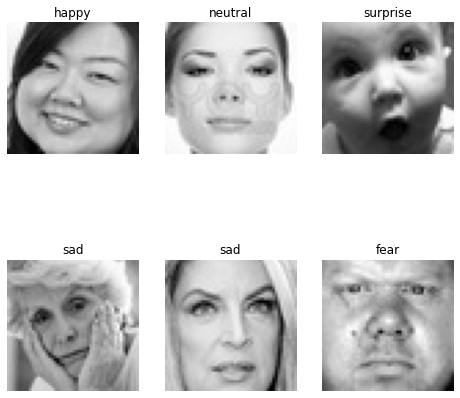

In [3]:
# Create training and testing datasets
# Reference 2: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# Reference 3: https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html

# Ref 2 starts =====
import os
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import matplotlib.pyplot as plt

classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]


# Custom dataset class
class FacialExpDataset(Dataset):
  def __init__(self, labels_csv, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(labels_csv)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path).float()
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

# Load the images into the datasets
# Ref 3 starts =====
one_hot_transform = Lambda(lambda y: torch.zeros(
    7, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
# ===== Ref 3 ends
train_data = FacialExpDataset("/content/train_labels.csv", train_root, 
                              target_transform=one_hot_transform)
test_data = FacialExpDataset("/content/test_labels.csv", test_root,
                             target_transform=one_hot_transform)

# Create dataloader for the datasets
batch_size = 3
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

# Print some sample images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[torch.argmax(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
# ===== Ref 2 ends


# Setting up common things for all different neural nets


In [4]:
# Build the convolutional neural network, train it, and test it
# Reference 4: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#
# Reference 5: https://github.com/patrickloeber/pytorchTutorial/blob/master/14_cnn.py

# ===== This block sets up the common things used for all neural nets =====

import time
# Ref 4 starts
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Ref 4 ends

# Switch to GPU for better resource performance
# Ref 5 starts =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")
# ===== Ref 5 ends

# Number of epochs, learning rate
num_epochs = 7
learning_rate = 0.001

# Loss function and optimizer
# Ref 4 starts =====
loss_func = nn.CrossEntropyLoss()
# ===== Ref 4 ends
def optimizer(net):
  # Ref 4 starts =====
  return optim.SGD(net.parameters(), lr=learning_rate)
  # ===== Ref 4 ends

# Training loop
# Ref 4 starts =====
def train(data_loader, net):
  total_batch_num = len(data_loader)
  running_loss = 0.0
  optim = optimizer(net)
  for i, (images, labels) in enumerate(data_loader):
    # transfer input tensors to gpu
    images = images.to(device)
    labels = labels.to(device)

    optim.zero_grad()
    
    outputs = net(images)
    loss = loss_func(outputs, labels)

    loss.backward()

    optim.step()

    running_loss += loss.item()
    if (i+1) % 2000 == 0:
      print(f'[{i+1}/{total_batch_num} batches]: avg loss = {running_loss/2000:.3f}')
      running_loss = 0.0

# Testing loop
def test(data_loader, net):
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)
      _, truth = torch.max(labels, 1)
      total += labels.size(0)
      correct += (predicted == truth).sum().item()
  return 100 * correct // total
# ===== Ref 4 ends

Training on cuda


# Original neural net from Pytorch tutorial

In [17]:
# ===== Original neural net from PyTorch tutorial =====
# Reference 6: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

exp_orig_csv = open("experiment_orig.csv", "a", newline='')
orig_csv_writer = csv.writer(exp_orig_csv)


o_group = 1
o_conv1_cn = 128
o_conv2_cn = 512
o_fc1_in = o_conv2_cn * 9 * 9
o_fc1_out = o_fc1_in // 4
o_fc2_out = o_fc1_out // 4

orig_csv_row = [o_group, o_conv1_cn, o_conv2_cn, o_fc1_in, o_fc1_out, o_fc2_out]

# Ref 6 starts =====
class OriginalNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, o_conv1_cn, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(o_conv1_cn, o_conv2_cn, 5)
    self.fc1 = nn.Linear(o_fc1_in, o_fc1_out)
    self.fc2 = nn.Linear(o_fc1_out, o_fc2_out)
    self.fc3 = nn.Linear(o_fc2_out, 7)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
# ===== Ref 6 ends


orig_nnet = OriginalNeuralNet().to(device)

# Custom neural net

In [31]:
# Reference 6: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

exp_custom_csv = open("experiment_custom.csv", "a", newline='')
custom_exp_writer = csv.writer(exp_custom_csv)

group = 2
conv1_cn = 64
conv2_cn = 128
conv3_cn = 256
conv4_cn = 512
fc1_in = conv4_cn * 9 * 9
fc1_out = fc1_in // 4
fc2_out = fc1_out // 4
custom_csv_row = [group, conv1_cn, conv2_cn, conv3_cn, conv4_cn, fc1_in, fc1_out, fc2_out]

# Define the neural network class and instantiate
class ConvNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, conv1_cn, 3)
    self.conv2 = nn.Conv2d(conv1_cn, conv2_cn, 3)
    self.conv3 = nn.Conv2d(conv2_cn, conv3_cn, 3)
    self.conv4 = nn.Conv2d(conv3_cn, conv4_cn, 3)
    # Ref 6 starts =====
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(fc1_in, fc1_out)
    self.fc2 = nn.Linear(fc1_out, fc2_out)
    self.fc3 = nn.Linear(fc2_out, 7)
    # ===== Ref 6 ends

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    # Ref 6 starts =====
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    # ===== Ref 6 ends

custom_nnet = ConvNeuralNet().to(device)

# Train & Test

In [ ]:
# ===== Train and test the network by each epoch =====
# Reference 4: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#

# Ref 4 starts =====
def train_test(net, csv_file, csv_writer, csv_row):
  total_train_time = 0.0
  for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}\n-------------------------------")
    start = time.time()
    train(train_loader, net)
    train_time = time.time() - start
    total_train_time += train_time

    train_res = test(train_loader, net)
    test_res = test(test_loader, net)
    csv_row.append(train_res)
    csv_row.append(test_res)
    print(f"Traing Set Accuracy: {train_res} %")
    print(f"Test Set Accuracy: {test_res} %")
# ===== Ref 4 ends

  print(f"\n----- Final Accuracy Verification -----")
  final_res = test(test_loader, net)
  csv_row.append(final_res)
  csv_row.append(total_train_time)
  print(f"Accuracy: {final_res}")

  # Save into experiment.csv
  csv_writer.writerow(csv_row)
  csv_file.flush()


train_test(custom_nnet, exp_custom_csv, custom_exp_writer, custom_csv_row)


# Experimentation Graphs

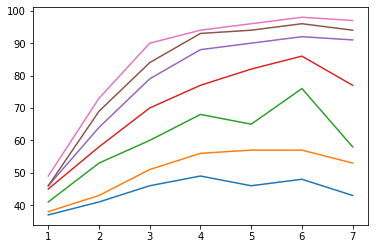

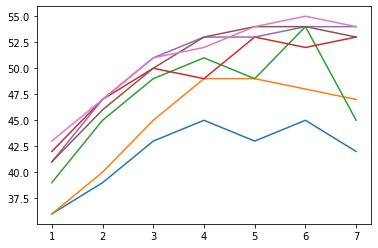

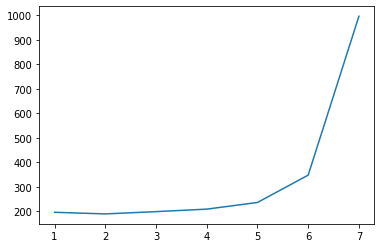

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

orig_exp = pd.read_csv("/content/experiment_orig.csv")

plt.figure("Original Net - Training")
plt.plot(orig_exp['group'], orig_exp.iloc[:,6:20:2])

plt.figure("Original Net - Testing")
plt.plot(orig_exp['group'], orig_exp.iloc[:,7:21:2])

plt.figure("Original Net - Train Time")
plt.plot(orig_exp['group'], orig_exp.iloc[:,21])

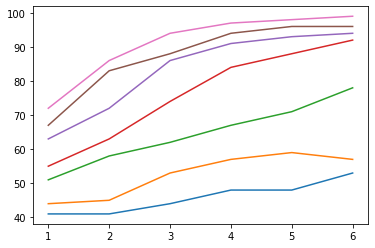

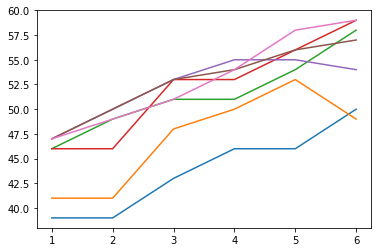

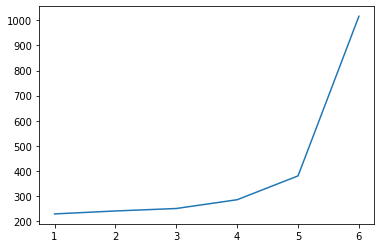

In [45]:
custom_exp = pd.read_csv("/content/experiment_custom.csv")

plt.figure("Custom Net - Training")
plt.plot(custom_exp['group'], custom_exp.iloc[:,8:22:2])

plt.figure("Custom Net - Testing")
plt.plot(custom_exp['group'], custom_exp.iloc[:,9:23:2])

plt.figure("Custom Net - Train Time")
plt.plot(custom_exp['group'], custom_exp.iloc[:,23])

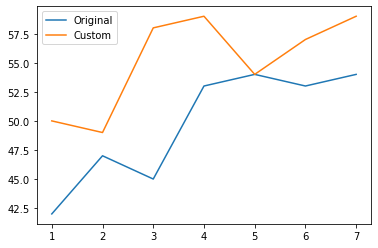

In [49]:
plt.figure("Comparison")
epochs = [1, 2, 3, 4, 5, 6, 7]
plt.plot(epochs, orig_exp.iloc[6,7:21:2], label="Original")
plt.plot(epochs, custom_exp.iloc[5, 9:23:2], label="Custom")
plt.legend()